# Background

> *this section provides an introduction to what graph-based data-driven weather models are and how they work. Inline code using `weather-model-graphs` is used to demonstrate different parts of the graph*

Current graph-based weather models use the [encode-process-decode paradigm](https://arxiv.org/abs/1806.01261) on [message-passing graphs](https://arxiv.org/abs/1704.01212) to do the auto-regressive temporal prediction of the atmospheric weather state to produce a weather forecast. 
The graphs are directed acyclic graphs (DAGs) with the nodes representing features (physical variables) at a given location in space and the edges representing flow of information.
The encode-process-decode paradigm is a three-step process that involves encoding the input data into a latent space, processing the latent space to make predictions, and decoding the predictions to produce the output data. 

## The graph nodes

Using the nomenclature of [Lam et al 2022](https://arxiv.org/abs/2212.12794) the nodes in `weather-model-graphs` are split into two types:

- **grid nodes**: representing the physical variables of the atmospheric state at a specific `(x,y)` coordinate in the (input) initial state to the model and the (output) prediction of the model

- **mesh nodes**: representing the latent space of the model at specific `(x,y)` coordinate in the intermediate (latent) representation of the model

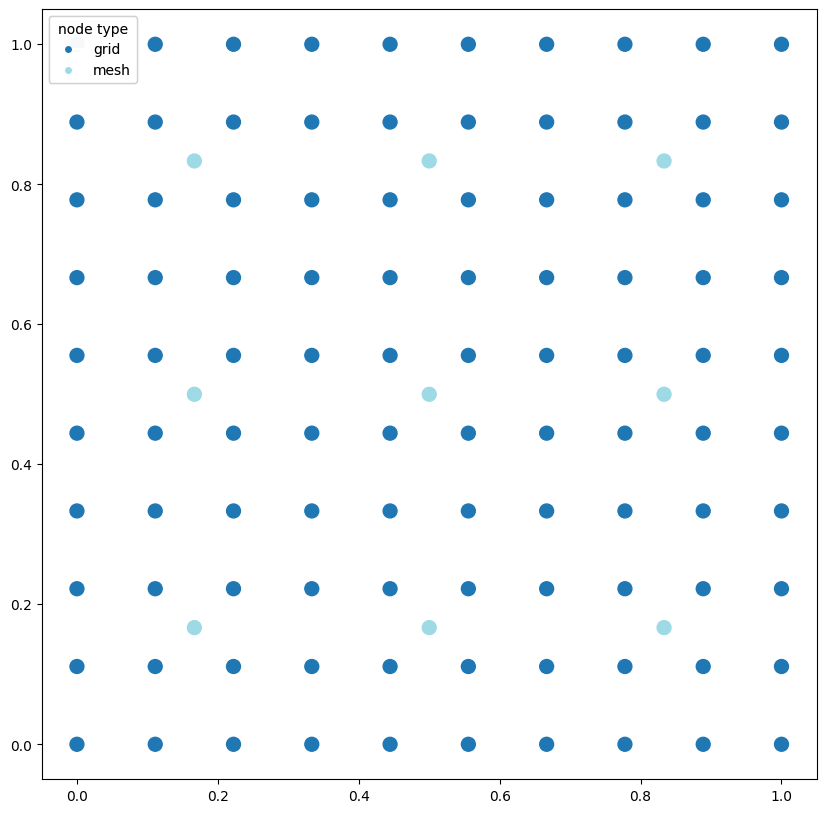

In [4]:
import numpy as np
import weather_model_graphs as wmg

# create some fake cartesian coordinates
def _create_fake_xy(N=10):
    x = np.linspace(0.0, 1.0, N)
    y = np.linspace(0.0, 1.0, N)
    xy = np.stack(np.meshgrid(x, y), axis=0)
    return xy


xy_grid = _create_fake_xy(N=10)

graph = wmg.create.archetype.create_keisler_graph(xy_grid=xy_grid)

# remove all edges from the graph
graph.remove_edges_from(list(graph.edges))

ax = wmg.visualise.nx_draw_with_pos_and_attr(graph, node_color_attr="type")

As you can see in the code snippet above, the only input that graph generation in `weather-model-graphs` requires are the static `(x,y)` *grid* coordinates of the atmospheric state as the state changes over time. These coordinates are used to create the **grid nodes** nodes of the graph, with a node for each `(x,y)` coordinate.

In addition to grid nodes the graph also contains **mesh nodes** that represent the latent space of the model at a set of `(x,y)` coordinates (this is in general a different set of coordinates to the **grid nodes** coordinates).

## The graph edges

With these two sets of nodes, the graph is constructed by connecting the **grid nodes** to the **mesh nodes** and the **mesh nodes** to each other.
The edges between the **grid nodes** and the **mesh nodes** represent the encoding of the physical variables into the latent space of the model, while the edges between the **mesh nodes** represent the processing of the latent space through the time evolution of the atmospheric state.

In summary, the complete message-passing graph consists of three components:

- **grid-to-mesh** (`g2m`): the encoding compenent, where edges represent the encoding of physical variables into the latent space of the model

- **mesh-to-mesh** (`m2m`): the processing component, where edges represent information flow between nodes updating the latent presentation at mesh nodes through the time evolution of the atmospheric state

- **mesh-to-grid** (`m2g`): the decoding component, where edges represent the decoding of the latent space back into physical variables

Practically, the **mesh-to-grid** and **grid-to-mesh** updates can probably also encode some of the time evolution processing, in addition to the latent space encoding/decoding, unless the GNN is trained specifically as an auto-encoder using the same graph as input and output.

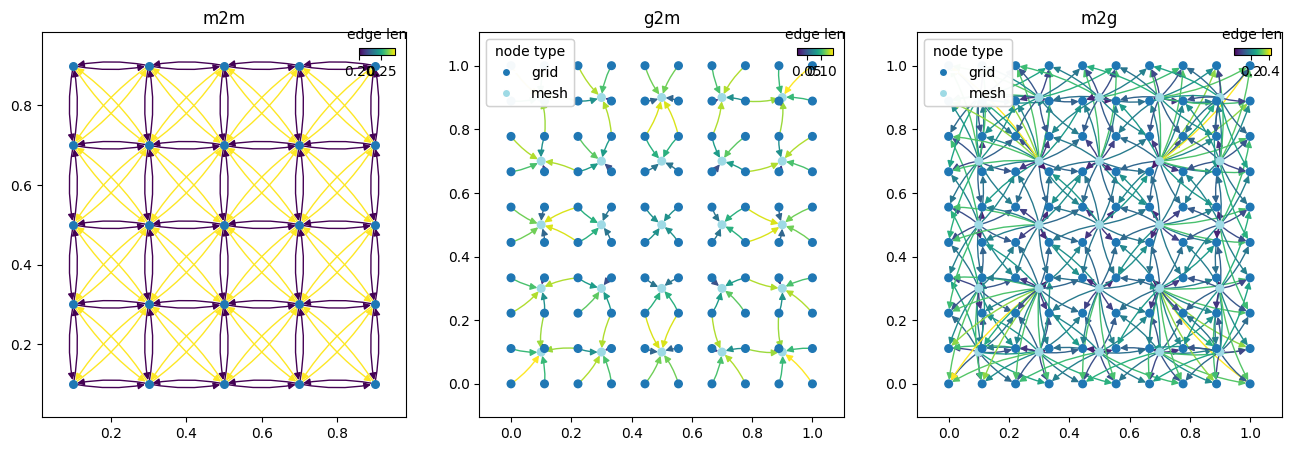

In [5]:
import matplotlib.pyplot as plt

graph = wmg.create.archetype.create_keisler_graph(xy_grid=xy_grid, grid_refinement_factor=2)
graph_components = wmg.split_graph_by_edge_attribute(graph=graph, attr="component")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

for (name, graph), ax in zip(graph_components.items(), axes.flatten()):
    pl_kwargs = {}
    if name == "m2m":
        pl_kwargs = dict(edge_color_attr="len")
    elif name == "g2m" or name == "m2g":
        pl_kwargs = dict(edge_color_attr="len", node_color_attr="type")

    wmg.visualise.nx_draw_with_pos_and_attr(graph, ax=ax, node_size=30, **pl_kwargs)
    ax.set_title(name)